In [1]:
from preprocess import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Function
from sklearn.model_selection import train_test_split

device = "cuda"

In [2]:
train_data_list = load_data3("train")
test_data_list = load_data3("test")

In [33]:
class FeatureExtractorEEG(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, padding=1),  # (32,8,9)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64,8,9)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # (64,4,4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (128,4,4)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1))  # (128,1,1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # (batch, 128)
        return x

class FeatureExtratorEYE(nn.Module):
    def __init__(self, input_dim=33, hidden_dim1=64, hidden_dim2=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x



In [34]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, hidden_dim1=128, hidden_dim2=128, output_dim=33):
        super().__init__()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        x = self.decoder(x) 
        return x

In [35]:
class BDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.ext1 = FeatureExtractorEEG()
        self.ext2 = FeatureExtratorEYE()

        self.fusion = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),   
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.dec1 = Decoder(output_dim=310)
        self.dec2 = Decoder(output_dim=33)
    
    def get_feature(self, x_eeg, x_eye):
        eeg_feat = self.ext1(x_eeg)
        eye_feat = self.ext2(x_eye)
        fused = torch.cat([eeg_feat, eye_feat], dim=1)
        return self.fusion(fused)
    
    def forward(self, x_eeg, x_eye):
        feat = self.get_feature(x_eeg, x_eye)
        return self.dec1(feat), self.dec2(feat)


In [ ]:
class MyClassifier(nn.Module):
    def __init__(self, bdae, num_classes=3):
        super().__init__()
        self.bdae = bdae

        for p in self.bdae.parameters():
            p.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(64, num_classes)
        )

    def forward(self, x_eeg, x_eye):
        with torch.no_grad(): 
            feat = self.bdae.get_feature(x_eeg, x_eye)
        return self.classifier(feat)


In [46]:
batch_size = 32
epochs = 30
# patience = 15

acc_list = []

# for i in [2]:
for i in range(12):

    X_EEG_train, X_EEG2_train, X_EYE_train, Y_train = train_data_list[i]
    X_EEG_test,X_EEG2_test, X_EYE_test, Y_test = test_data_list[i]

    eeg_scaler, X_EEG_train = fit_transform(X_EEG_train)
    X_EEG_test = transform(eeg_scaler, X_EEG_test)

    eeg2_scaler, X_EEG2_train = fit_transform(X_EEG2_train)
    X_EEG2_test = transform(eeg2_scaler, X_EEG2_test)

    eye_scaler, X_EYE_train = fit_transform(X_EYE_train)
    X_EYE_test = transform(eye_scaler, X_EYE_test)

    train_dataset = BDAEDataset(X_EEG_train, X_EEG2_train, X_EYE_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = BDAEDataset(X_EEG_test, X_EEG2_test, X_EYE_test, Y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    bdae = BDAE().to(device)
    optimizer1 = torch.optim.Adam(bdae.parameters(), lr=1e-3, weight_decay=5e-4)
    criterion1 = F.smooth_l1_loss
    criterion2 = F.smooth_l1_loss

    for epoch in range(5):

        bdae.train()

        train_loss = 0  
        test_loss = 0

        for x_eeg, x_eeg2, x_eye, y in train_loader:
            x_eeg, x_eeg2, x_eye, y = x_eeg.to(device), x_eeg2.to(device), x_eye.to(device), y.to(device)
            optimizer1.zero_grad()
            x1, x2 = bdae(x_eeg, x_eye)
            loss1 = criterion1(x1, x_eeg2)
            loss2 = criterion2(x2, x_eye)
            loss = loss1 + 0.3 * loss2
            loss.backward()
            optimizer1.step()
            
            train_loss += loss

        train_loss = train_loss / len(train_loader)

        bdae.eval()

        with torch.no_grad():
            for x_eeg, x_eeg2, x_eye, y in test_loader:
                x_eeg, x_eeg2, x_eye, y = x_eeg.to(device), x_eeg2.to(device), x_eye.to(device), y.to(device)
                x1, x2 = bdae(x_eeg, x_eye)
                test_loss += criterion1(x1, x_eeg2) + 0.3 * criterion2(x2, x_eye)

        test_loss = test_loss / len(test_loader)

        print(f"epoch {epoch+1}: train_loss: {train_loss:.4f} test_loss: {test_loss:.4f}")

        if epoch % 5 == 0:
            with torch.no_grad():
                sample_eeg, sample_eeg2, sample_eye, y = next(iter(test_loader))
                recon_eeg, recon_eye = bdae(sample_eeg.to(device), sample_eye.to(device))

                print(recon_eye)
                print(sample_eye)

            with torch.no_grad():
                feat = bdae.get_feature(x_eeg, x_eye)
                print("latent std:", feat.std(dim=0).mean().item())


    model = MyClassifier(bdae).to(device)

    optimizer = torch.optim.Adam(
        model.classifier.parameters(), 
        lr=1e-3,
        weight_decay=5e-4
    )

    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for x_eeg, _, x_eye, y in train_loader:
            x_eeg = x_eeg.to(device)
            x_eye = x_eye.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(x_eeg, x_eye)
            loss = criterion(logits, y)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_eeg, _, x_eye, y in test_loader:
                x_eeg = x_eeg.to(device)
                x_eye = x_eye.to(device)
                y = y.to(device)

                logits = model(x_eeg, x_eye)
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        test_acc = correct / total

        print(
            f"Epoch {epoch+1:03d} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        if epoch == epochs - 1 or train_acc > 0.95:
            acc_list.append(test_acc)
            print(f"acc {i} = {acc_list[-1]}")
            break



epoch 1: train_loss: 0.2880 test_loss: 186.8655
tensor([[ 3.4798e-01, -2.1520e-01,  3.8994e-01,  ...,  5.2274e-01,
          8.1063e-01, -1.2880e-02],
        [-4.1263e+03, -5.4231e+03, -3.8920e+03,  ..., -2.9668e+03,
         -4.1157e+02,  4.1261e+03],
        [-2.0381e-01,  3.7501e-02, -2.2832e-01,  ..., -2.1607e-01,
          9.0705e-02,  1.1424e-01],
        ...,
        [ 1.1053e-02,  1.6793e-01,  1.0277e-02,  ..., -2.8102e-02,
          2.9090e-01, -3.3586e-01],
        [ 5.0231e-01, -9.8369e-02,  5.9010e-01,  ...,  7.0457e-02,
          1.8070e+00, -5.1877e-01],
        [ 3.1749e-01,  8.5717e-02,  2.9300e-01,  ..., -1.3095e-01,
         -2.3133e-01, -5.1651e-01]], device='cuda:0')
tensor([[-6.6082e-01, -3.5696e-01, -6.6170e-01,  ...,  6.3984e-01,
          5.7772e-01,  1.7416e-01],
        [-1.2103e+00, -2.1017e+00, -1.1800e+00,  ..., -5.3790e+01,
          2.8678e+01, -1.2543e+00],
        [-9.4817e-01,  3.6397e-02, -9.5307e-01,  ...,  1.4737e+00,
          1.7751e-02,  1.1994e

[0.6870748299319728, 0.60932944606414, 0.7482993197278912, 0.6822157434402333, 0.6754130223517979, 0.7881438289601554, 0.718172983479106, 0.8134110787172012, 0.9436345966958212, 0.7191448007774538, 0.7871720116618076, 0.8211856171039844]
LOSO Mean Accuracy: 0.7494, Std: 0.0843


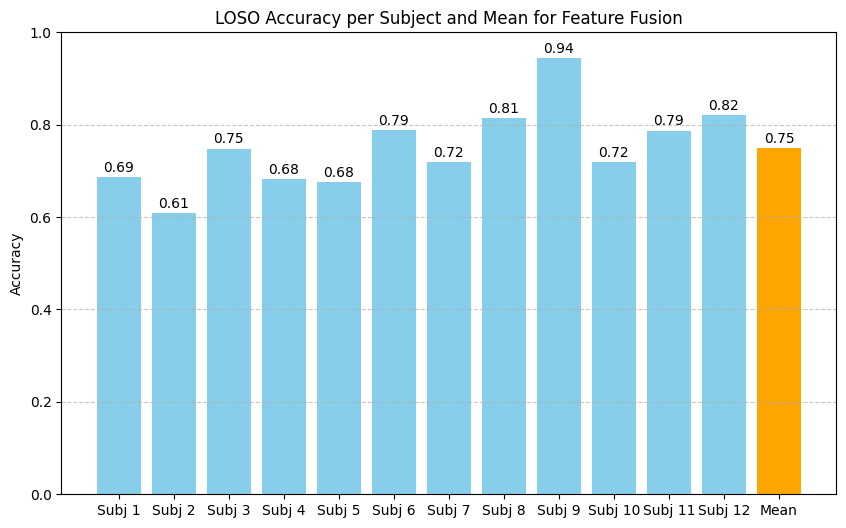

In [47]:
print(acc_list)
mean_acc = np.mean(acc_list)
std_acc = np.std(acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean for Feature Fusion")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

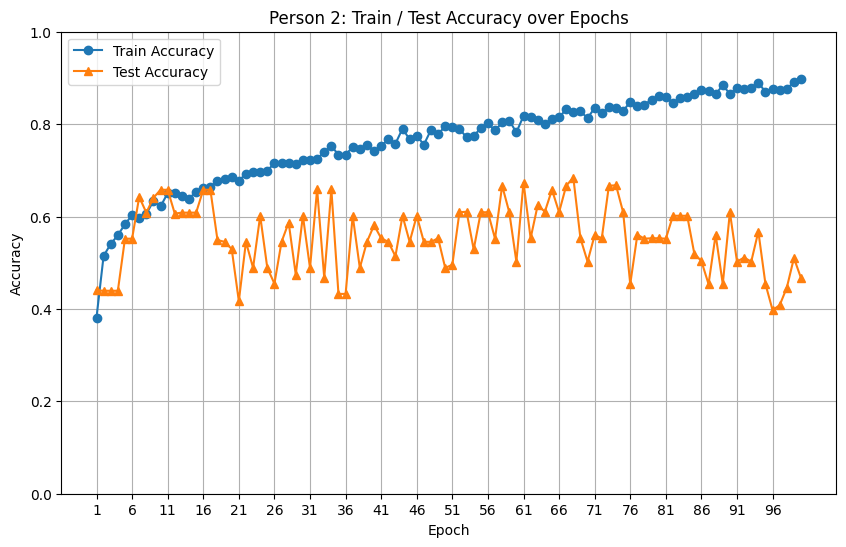

In [40]:
import matplotlib.pyplot as plt

# 训练准确率 (Train Acc)
train_acc = [
    0.3814, 0.5150, 0.5404, 0.5598, 0.5832, 0.6032, 0.5959, 0.6059, 0.6333, 0.6219,
    0.6506, 0.6513, 0.6446, 0.6386, 0.6540, 0.6607, 0.6647, 0.6760, 0.6814, 0.6860,
    0.6774, 0.6927, 0.6974, 0.6954, 0.6994, 0.7154, 0.7154, 0.7168, 0.7128, 0.7214,
    0.7214, 0.7248, 0.7401, 0.7522, 0.7341, 0.7341, 0.7502, 0.7462, 0.7555, 0.7408,
    0.7528, 0.7669, 0.7575, 0.7902, 0.7669, 0.7749, 0.7555, 0.7876, 0.7782, 0.7956,
    0.7943, 0.7896, 0.7715, 0.7742, 0.7916, 0.8016, 0.7862, 0.8036, 0.8076, 0.7822,
    0.8176, 0.8163, 0.8096, 0.8003, 0.8110, 0.8150, 0.8317, 0.8263, 0.8277, 0.8130,
    0.8350, 0.8230, 0.8363, 0.8343, 0.8283, 0.8484, 0.8383, 0.8424, 0.8530, 0.8604,
    0.8591, 0.8450, 0.8570, 0.8577, 0.8657, 0.8744, 0.8724, 0.8651, 0.8838, 0.8657,
    0.8784, 0.8758, 0.8791, 0.8898, 0.8697, 0.8758, 0.8737, 0.8764, 0.8911, 0.8978
]

# 测试准确率 (Test Acc)
test_acc = [
    0.4402, 0.4393, 0.4393, 0.4393, 0.5520, 0.5520, 0.6424, 0.6084, 0.6404, 0.6579,
    0.6579, 0.6064, 0.6084, 0.6084, 0.6084, 0.6579, 0.6579, 0.5491, 0.5452, 0.5296,
    0.4169, 0.5452, 0.4888, 0.6016, 0.4888, 0.4548, 0.5452, 0.5870, 0.4742, 0.6016,
    0.4888, 0.6589, 0.4674, 0.6589, 0.4325, 0.4325, 0.6016, 0.4888, 0.5452, 0.5811,
    0.5530, 0.5452, 0.5141, 0.6016, 0.5452, 0.6016, 0.5452, 0.5452, 0.5530, 0.4888,
    0.4956, 0.6093, 0.6103, 0.5287, 0.6093, 0.6093, 0.5520, 0.6667, 0.6093, 0.5024,
    0.6735, 0.5530, 0.6249, 0.6103, 0.6579, 0.6093, 0.6667, 0.6842, 0.5530, 0.5024,
    0.5598, 0.5530, 0.6667, 0.6676, 0.6093, 0.4538, 0.5607, 0.5520, 0.5530, 0.5530,
    0.5520, 0.6016, 0.6016, 0.6016, 0.5199, 0.5034, 0.4538, 0.5607, 0.4538, 0.6093,
    0.5024, 0.5112, 0.5024, 0.5675, 0.4538, 0.3975, 0.4082, 0.4461, 0.5102, 0.4665
]

# 构建 x 轴：1-base epoch
epochs = list(range(1, len(train_acc)+1))  # 1,2,...20

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, test_acc, marker='^', label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Person 2: Train / Test Accuracy over Epochs')
plt.xticks(range(1, len(train_acc)+1, 5))
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.show()
